# **9.7 Mini-Project: SQLite DB Creation**

Thomas Butler, vra2cf
Bryan DeMarcy, bd2qn
Jake Kolessar, jak4as

Our team created a database based on Seattle Pet Licenses with tax return and location information based on zipcode.

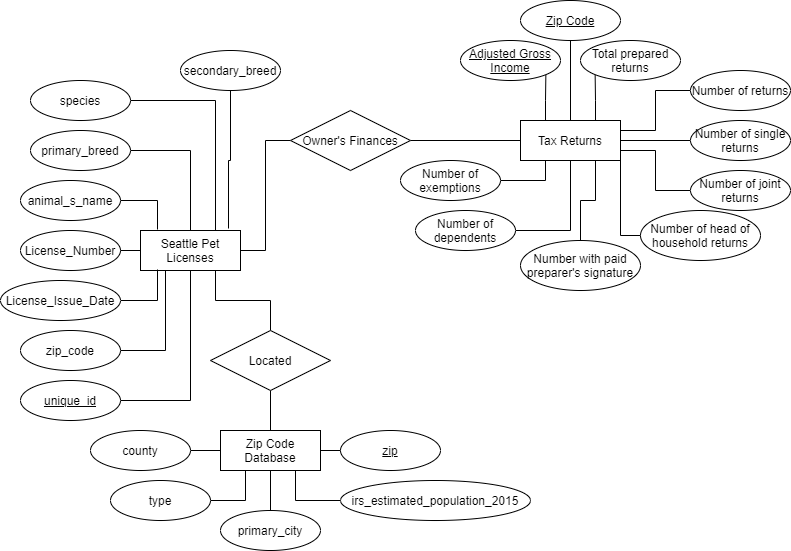

**Entity Set Tables**

Seattle Pet Licenses (**unique_id**, License_Issue_Date, zip_code, primary_breed, License_Number, animal_s_name, secondary_breed, species)

Tax Returns (**Zip Code**, **Adjusted Gross Income**, Total prepared returns, Number of returns, Number of single returns, Number of joint returns, Number of head of household returns, Number with paid preparer’s signature, Number of dependents, Number of exemptions)

Zip Code Database (**zip**, irs_estimate_population_2015, primary_city, type, county)

**Relationship Set Tables**
(combined zip code attribute from different tables under the name zip_code)

Owner’s Finances (**unique_id, zip_code, Adjusted Gross Income**)

Located (**unique_id, zip_code**)

Note: all primary keys have been bolded instead of underlined because I couldn't find a way to underline text in colab.

In [1]:
import sqlite3
import pandas as pd

#put csv files into pandas dataframes
zip_df = pd.read_csv('https://raw.githubusercontent.com/Toble007/File_Storage_Colab/main/zip_code_database.csv')
spl_df = pd.read_csv('https://raw.githubusercontent.com/Toble007/File_Storage_Colab/main/seattle_pet_licenses.csv')
wa_income_df = pd.read_csv('https://raw.githubusercontent.com/Toble007/File_Storage_Colab/main/wa_incomes_zip_code.csv')

conn = sqlite3.connect('seattlePetLicense.db')
c = conn.cursor()

#if these tables exist drop them.
c.execute(""" 
drop table if exists seattle_pet_licenses
""")
c.execute(""" 
drop table if exists taxReturns
""")
c.execute(""" 
drop table if exists zipCodeDatabase
""")

#function written to insert values into the tables.
def populate_tables(zip_df, spl_df, wa_income_df):
    with conn:
        for i,val in enumerate(zip_df['zip']):
            c.execute("""INSERT INTO zipCodeDatabase VALUES (:zip_code, :county, :type, :primary_city, :irs_est_pop)""",
                      {'zip_code': val, 'county':zip_df['county'].loc[i], 'type':zip_df['type'].loc[i], 
                       'primary_city':zip_df['primary_city'].loc[i], 'irs_est_pop': int.from_bytes(zip_df['irs_estimated_population_2015'][i],'little')})
        for i, val in enumerate(spl_df['license_issue_date']):
            c.execute("""INSERT INTO seattle_pet_licenses VALUES (:unique_id, :license_date, :zip, :primary_breed, :license_number, :animal_s_name, :secondary, :species)""",
                      {'unique_id':i, 'license_date':spl_df['license_issue_date'].loc[i], 'zip':spl_df['zip_code'].loc[i],
                       'primary_breed':spl_df['primary_breed'].loc[i], 'license_number':spl_df['license_number'].loc[i],
                       'animal_s_name':spl_df['animal_s_name'].loc[i], 'secondary':spl_df['secondary_breed'].loc[i], 'species':spl_df['species'].loc[i]})
        for i, val in enumerate(wa_income_df['Zip Code']):
            c.execute("""INSERT INTO taxReturns VALUES (:zip_code, :adj_gross_income, :tot_prep_returns, :num_returns, :num_single_returns, :num_joint_returns, :num_hoh_returns, :num_paid_prep_sig, :num_depends, :num_exemptions)""",
                      {'zip_code': val, 'adj_gross_income':wa_income_df['Adjusted Gross Income'].loc[i],
                       'tot_prep_returns': int.from_bytes(wa_income_df['Total prepared returns'].loc[i],"little"), 'num_returns':int.from_bytes(wa_income_df['Number of returns'].loc[i],"little"),
                       'num_single_returns':int.from_bytes(wa_income_df['Number of single returns'].loc[i],"little"), 'num_joint_returns':int.from_bytes(wa_income_df['Number of joint returns'].loc[i],"little"),
                       'num_hoh_returns':int.from_bytes(wa_income_df['Number of head of household returns'].loc[i],"little"), 'num_paid_prep_sig':int.from_bytes(wa_income_df["Number with paid preparer's signature"].loc[i],"little"),
                       'num_depends':int.from_bytes(wa_income_df['Number of dependents'].loc[i],"little"), 'num_exemptions':int.from_bytes(wa_income_df['Number of exemptions'].loc[i], "little")})
            

#creating SQL tables
c.execute("""CREATE TABLE seattle_pet_licenses (
            unique_id INTEGER IDENTITY(1,1),
            license_issue_date VARCHAR,
            zip_code VARCHAR,
            primary_breed VARCHAR,
            license_number INTEGER,
            animal_s_name VARCHAR,
            secondary_breed VARCHAR,
            species VARCHAR,
            PRIMARY KEY (unique_id)
            )""")

c.execute("""CREATE TABLE taxReturns (
            zip_code VARCHAR,
            adjusted_gross_income INTEGER,
            total_prepared_returns INTEGER,
            number_of_returns INTEGER,
            number_of_single_returns INTEGER,
            number_of_joint_returns INTEGER,
            number_of_head_of_household_returns INTEGER,
            number_with_paid_preparer_signature INTEGER,
            number_of_dependents INTEGER,
            number_of_exemptions INTEGER,
            PRIMARY KEY (zip_code, adjusted_gross_income)
            )""")

c.execute("""CREATE TABLE zipCodeDatabase (
            zip_code VARCHAR,
            county VARCHAR,
            type VARCHAR,
            primary_city VARCHAR,
            irs_estimated_population_2015 INTEGER,
            PRIMARY KEY (zip_code)
            )""")

conn.commit()

populate_tables(zip_df, spl_df, wa_income_df)


In [2]:
#to check the tables populated properly
c.execute('''
select *
from seattle_pet_licenses
LIMIT 10
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["unique_id", "license_issue_date", "zip_code", "primary_breed", "license_number", "animal_s_name", "secondary_breed", "species"])
df.head()

,unique_id,license_issue_date,zip_code,primary_breed,license_number,animal_s_name,secondary_breed,species
0,0,2005-03-29T00:00:00.000,98104,"Dachshund, Standard Smooth Haired",130651,Ozzy,None,Dog
1,1,2009-12-23T00:00:00.000,98107,"Schnauzer, Miniature",898148,Jack,"Terrier, Rat",Dog
2,2,2006-01-20T00:00:00.000,98117,"Retriever, Golden",29654,Ginger,"Retriever, Labrador",Dog
3,3,2006-02-07T00:00:00.000,98103,Manx,75432,Pepper,Mix,Cat
4,4,2006-08-04T00:00:00.000,98105,"Retriever, Golden",729899,Addy,None,Dog


In [3]:
#to check the tables populated properly
c.execute('''
select *
from taxReturns
LIMIT 10
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["zip_code", "adjusted_gross_income", "total_prepared_returns", "number_of_returns", "number_of_single_returns", "number_of_joint_returns", "number_of_head_of_household_returns", "number_with_paid_preparer_signature", "number_of_dependents", "number_of_exemptions"])
df.head()

,zip_code,adjusted_gross_income,total_prepared_returns,number_of_returns,number_of_single_returns,number_of_joint_returns,number_of_head_of_household_returns,number_with_paid_preparer_signature,number_of_dependents,number_of_exemptions
0,98001,"$1 under $25,000",140,4420,3280,530,560,1710,1640,5590
1,98001,"$25,000 under $50,000",90,3750,2130,930,620,1570,2350,6990
2,98001,"$50,000 under $75,000",30,2520,1010,1140,340,1160,2000,5670
3,98001,"$75,000 under $100,000",0,1850,430,1250,140,840,1500,4600
4,98001,"$100,000 under $200,000",0,2680,290,2270,120,1280,2370,7320


In [4]:
#to check the tables populated properly
c.execute('''
select *
from zipCodeDatabase
LIMIT 10
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["zip_code","county","type","primary_city","irs_estimated_population_2015"])
df.head()

,zip_code,county,type,primary_city,irs_estimated_population_2015
0,501,Suffolk County,UNIQUE,Holtsville,562
1,544,Suffolk County,UNIQUE,Holtsville,0
2,601,Adjuntas Municipio,STANDARD,Adjuntas,0
3,602,Aguada Municipio,STANDARD,Aguada,0
4,603,Aguadilla Municipio,STANDARD,Aguadilla,0


## Queries and Visualizations

### Query 1: Find the ratio of Seattle residents to pet licenses issued in 2015.

As we can see from the results below, there were 29,339 Seattle residents for every pet license issued in 2015.

In [5]:
# Query 1: How many Seattle residents are there for every pet license issued in 2015?
c.execute('''
select sum(t2.irs_estimated_population_2015)/count(t1.unique_id) as person_per_license
from seattle_pet_licenses t1
inner join zipCodeDatabase t2
on t1.zip_code = t2.zip_code
where substr(t1.license_issue_date,1,4) = '2015'
	and t2.primary_city = 'Seattle'
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["person_per_license"])
df

,person_per_license
0,29339


### Query 2: How many Seattle pet licenses were issued annually between 2010 and 2016?

The number of pet licenses increased gradually between 2010 and 2014 before drastically increasing in 2015. The number of licenses issued in 2015 increased by 25,575 licenses compared to the previous year.

   Year  LicenseCount
0  2010             8
1  2011            10
2  2012            23
3  2013           364
4  2014          3421
5  2015         28996
6  2016         33198


<AxesSubplot:xlabel='Year'>

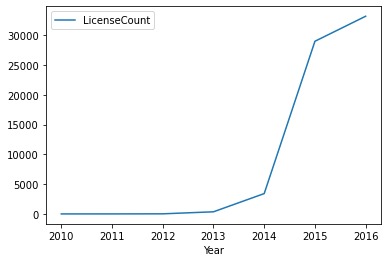

In [6]:
# Query 2: How many Seattle pet licenses were issued annually between 2010 and 2016?
c.execute('''
select substr(license_issue_date,1,4) as Year, count(unique_id) as LicenseCount
from seattle_pet_licenses
where substr(license_issue_date,1,4) in ('2010','2011','2012','2013','2014','2015','2016')
group by year
order by year asc
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["Year","LicenseCount"])

print(df)

df.plot.line(x='Year', y='LicenseCount')

### Query 3: How many pet license numbers have been issued for each species in the dataset?

Only distinct pets were included in this query since some pets had their pet license renewed annually. There are 25 livestock, 15182 cats, and 27032 dogs with pet licenses in this dataset.

             species  LicenseCount
Cat              Cat         15182
Dog              Dog         27032
Livestock  Livestock            25


<AxesSubplot:ylabel='LicenseCount'>

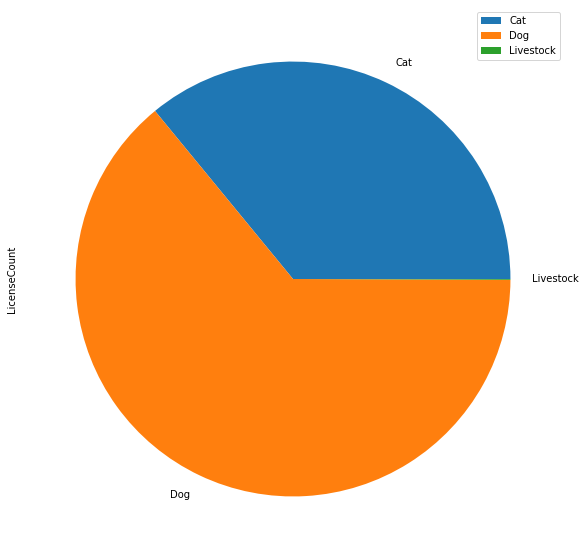

In [7]:
# Query 3: How many license numbers have been issued for each species in the dataset?
c.execute('''
select species, count(distinct license_number) as LicenseCount
from seattle_pet_licenses
group by species
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["species", "LicenseCount"], index=['Cat','Dog','Livestock'])
print(df)

df.plot.pie(y='LicenseCount', figsize=(10,10))

### Query 4: How many instances was a pet issued more than one unique id grouped by species? 

This is an indication for how many times a pet license was renewed. We subtract the number of distinct pet license numbers from the total number of observations with a pet license. Only 1 livestock pet had their license renewed while 635 cats and 1010 dogs had their licenses renewed.

In [8]:
# Query 4: How many instances was a pet issued more than one unique id grouped by species? This is an indication for how many times a pet license was renewed.
c.execute('''
select species, count(license_number) - count(distinct license_number) as IDcount
from seattle_pet_licenses
group by species
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["species", "IDcount"])
df

,species,IDcount
0,Cat,635
1,Dog,1010
2,Livestock,1


### Query 5: How many unique livestock pet licenses were issued for each Seattle zip code in the dataset?

This query reveals the Seattle zip codes that contain the most livestock. Zip code 98112, 98177, and 98115 contain the most livestock with 6, 4, and 3, respectively. There are 5 additional zip codes that contain 2 livestock each and 2 zip codes with 1 livestock each. The remaining zip codes did not have any livestock pet licenses in the dataset.

   zip_code  LicenseCount
0     98112             6
1     98177             4
2     98115             3
3     98126             2
4     98122             2
5     98118             2
6     98108             2
7     98106             2
8     98117             1
9     98107             1
10    98144             0
11    98133             0
12    98105             0
13    98103             0


<AxesSubplot:xlabel='zip_code'>

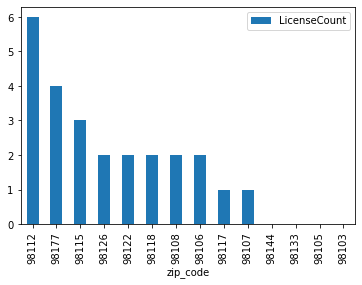

In [9]:
# Query 5: How many unique livestock pet licenses were issued for each Seattle zip code in the dataset?
c.execute('''
select t1.zip_code, count(distinct t2.license_number) as LicenseCount
from zipCodeDatabase t1
left join seattle_pet_licenses t2
on t1.zip_code = t2.zip_code
where t1.primary_city = 'Seattle' and t2.species = 'Livestock'
group by t1.zip_code
order by LicenseCount desc
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["zip_code", "LicenseCount"])
print(df)

df.plot.bar(x='zip_code',y='LicenseCount')

### Query 6: What are the five most popular dog breeds in Seattle?

The most popular primary dog breed in Seattle, by far, is the Labrador Retriever with 4,153 pet licences. The next 4 popular breeds are Golden Retriever, Short Coat Chihuahua, Australian Shepherd, and German Shepherd.

In [10]:
# Query 6: What are the five most popular dog breeds in Seattle?
c.execute('''
select primary_breed, count(distinct license_number) as BreedCount
from seattle_pet_licenses
where species = 'Dog'
group by primary_breed
order by BreedCount desc
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["zip_code", "LicenseCount"])
df.head(5)

,zip_code,LicenseCount
0,"Retriever, Labrador",4153
1,"Retriever, Golden",1533
2,"Chihuahua, Short Coat",1281
3,Australian Shepherd,810
4,German Shepherd,784


### Query 7: What were the most popular pet names in the year 2015?

The most popular Seattle pet name in 2015 was Lucy with 200 distinct pet licenses containing that name. Note that we exclude instances where no pet name was recorded in the dataset.

In [11]:
# Query 7: What were the most popular pet names in the year 2015?
c.execute('''
select animal_s_name, count(distinct license_number) as NameCount
from seattle_pet_licenses
where substr(license_issue_date,1,4) = '2015' and animal_s_name <> 'None'
group by animal_s_name
order by NameCount desc
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["animal_s_name", "NameCount"])
df.head(10)

,animal_s_name,NameCount
0,Lucy,200
1,Bella,167
2,Charlie,142
3,Max,115
4,Jack,113
5,Lily,112
6,Buddy,111
7,Molly,108
8,Luna,107
9,Sophie,106


### Query 8: What is the number of each species registered per year?

Below is the table for number of each species registered for each year in our database. 

Note the increase in registrations starting in 2013 and the addition of Livestock in 2015.

      Species  Number of Species registered  Year
0         Dog                             1  2005
1         Dog                             3  2006
2         Cat                             1  2006
3         Dog                             3  2007
4         Cat                             1  2007
5         Dog                             8  2008
6         Cat                             1  2008
7         Dog                             4  2009
8         Dog                             8  2010
9         Dog                             9  2011
10        Cat                             1  2011
11        Dog                            18  2012
12        Cat                             5  2012
13        Dog                           266  2013
14        Cat                            98  2013
15        Dog                          2074  2014
16        Cat                          1347  2014
17        Dog                         18642  2015
18        Cat                         10336  2015


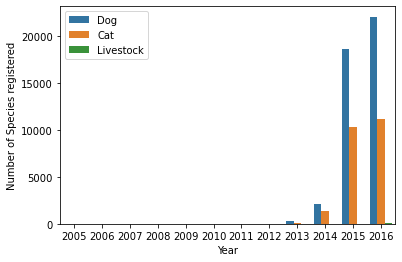

In [12]:
# Query 8: What is the number of each species registered per year?

import seaborn as sns
import matplotlib.pyplot as plt

c.execute('''
select species, count(species) as c_species, substr(license_issue_date,1,4) as Year
from seattle_pet_licenses
group by Year, species
order by Year asc, c_species desc
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["Species", "Number of Species registered", "Year"])
print(df)

ax = sns.barplot(x="Year", y="Number of Species registered", hue="Species", data=df)
plt.legend(loc='upper left')

### Query 9: Which zipcode had the greatest amount of each species registered? How much was each?

Zip Code 98115 held the most registered Dogs (5922 registered) and Livestock (9 registered). 

Zip Code 98103 held the most registered Cats (5623 registered)

In [13]:
# Query 9:Which zipcode had the greatest amount of each species registered? How much was each?

c.execute('''
select zip_code, species, max(c_species) as m_species
from (select zip_code, species, count(species) as c_species
from seattle_pet_licenses
group by zip_code)
where species = ("Cat")
union
select zip_code, species, max(c_species) as m_species
from (select zip_code, species, count(species) as c_species
from seattle_pet_licenses
group by zip_code)
where species = ("Dog")
union
select zip_code, species, max(c_species) as m_species
from (select zip_code, species, count(species) as c_species
from seattle_pet_licenses
where species in ("Livestock")
group by zip_code)
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["Zip Code", "Most registered species", "Max Species"])
print(df)

  Zip Code Most registered species  Max Species
0    98103                     Cat         5623
1    98115                     Dog         5922
2    98115               Livestock            9


### Query 10: What is the average adjusted gross income, adjusted gross income per capita, and average number of dependents for the Seattle zip code with the most distinct pet licenses issued in 2015?

*Note: The adjusted_gross_income field represents a pay band so we set the income as the minimum of each band. In reality, not every resident will have an income at the minimum of the pay band. Thus, the AverageIncome and IncomePerCapita calculated fields should be regarded as the minimum average rather than the true average. Also, the tax return data may not be from 2015 so that adds additional error into our calculations. These calculated fields are for demonstration purposes only.*

Seattle zip code 98115 had the most licenses issued in 2015 corresponding to 2,116 licenses. The average income for Seattle residents in this zip code was \$69,432.08. The income per capita for this zip code is \$39,258.39 which is almost half of the average income. This makes sense since children likely will not have an adjusted gross income to contribute to the tax filings; however, they are still counted in the estimated population. Also, the tax filings dataset may not be from 2015. On average, there are 0.44 dependents for every tax return in this zip code which suggests there is roughly 1 dependent for every two submitted tax returns.


In [14]:
# Query 10: What is the average adjusted gross income, adjusted gross income per capita, and average number of dependents for the Seattle zip code with the most distinct pet licenses issued in 2015?

c.execute('''
drop table if exists temp1
''')

# Create a temporary table to use in a subquery later. This temporary table provides a count of the number of licenses issued for each Seattle zip code in 2015.
c.execute('''
create table temp1 as
select zip_code, count(distinct license_number) as LicenseCount
from seattle_pet_licenses
where substr(license_issue_date,1,4) = '2015'
group by zip_code
''')

c.execute('''
drop table if exists temp2
''')

# Create a second temporary table that converts the adjusted_gross_income field to a numeric value to be used in aggregate functions later.
c.execute('''
create table temp2 as
select t1.*, 
       case when t1.adjusted_gross_income = '$1 under $25,000' then 1*t1.number_of_returns
            when t1.adjusted_gross_income = '$25,000 under $50,000' then 25000*t1.number_of_returns
            when t1.adjusted_gross_income = '$50,000 under $75,000' then 50000*t1.number_of_returns
            when t1.adjusted_gross_income = '$75,000 under $100,000' then 75000*t1.number_of_returns
            when t1.adjusted_gross_income = '$100,000 under $200,000' then 100000*t1.number_of_returns
            when t1.adjusted_gross_income = '$200,000 or more' then 200000*t1.number_of_returns
            else 0 end as numeric_gross_income
from taxReturns t1
''')

# Calculate the average income, income per capita, and average number of dependents.
c.execute('''
select t1.zip_code,
       t1.LicenseCount,
       round(sum(cast(t2.numeric_gross_income as float))/sum(t2.number_of_returns),2) as AverageIncome,
       round(sum(cast(t2.numeric_gross_income as float))/t3.irs_estimated_population_2015,2) as IncomePerCapita, 
       round(sum(cast(t2.number_of_dependents as float))/sum(t2.number_of_returns),2) as AverageDependents
from temp1 t1
inner join temp2 t2
on t1.zip_code = t2.zip_code
inner join zipCodeDatabase t3
on t1.zip_code = t3.zip_code
where t1.LicenseCount = (select max(LicenseCount) from temp1)
''')

data = c.fetchall()

df = pd.DataFrame(data, columns=["Zip Code","LicenseCount","AverageIncome","IncomePerCapita","AverageDependents"])
print(df)

  Zip Code  LicenseCount  AverageIncome  IncomePerCapita  AverageDependents
0    98115          2116       69432.08         39258.39               0.44
